This example shows that how the coupling between pairs of nodes can be one single constant or an array $A_{ij}$ with individual coupling for each pair of nodes *i,j* (ie the adjacency/coupling matrix)

In [1]:
import numpy as np
import networkx as nx

from kuramoto import Kuramoto, plot_activity, plot_phase_coherence

In [2]:
# Instantiate a random graph and transform into an adjacency matrix
n_nodes = 100
adj_mat = nx.to_numpy_array(nx.erdos_renyi_graph(n=n_nodes, p=1))  # p=1 -> all-to-all connectivity

In [3]:
adj_mat

array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.]], shape=(100, 100))

In [4]:
# Instantiate model with parameters
coupling = 3
model = Kuramoto(coupling=coupling, dt=0.01, T=10, n_nodes=n_nodes)                 

# Fix initial state for later comparison
angles = 2 * np.pi * np.random.random(size=n_nodes)

# Run simulation - output is time series for all nodes (node vs time)
act_mat = model.run(adj_mat=adj_mat, angles_vec=angles)
print(act_mat.shape)

(100, 1000)


Generate another coupling as 2D array but with the same constant for all pairs.
The goal is to have something equivalent to the single float scenario

In [5]:
adj_mat = adj_mat*coupling
adj_mat

array([[0., 3., 3., ..., 3., 3., 3.],
       [3., 0., 3., ..., 3., 3., 3.],
       [3., 3., 0., ..., 3., 3., 3.],
       ...,
       [3., 3., 3., ..., 0., 3., 3.],
       [3., 3., 3., ..., 3., 0., 3.],
       [3., 3., 3., ..., 3., 3., 0.]], shape=(100, 100))

In [6]:
# Swap the coupling in the model
model.coupling = 1

# Run activity again (with same initial state)
act_mat_new = model.run(adj_mat=adj_mat, angles_vec=angles)

# Compare activity of both runs
np.isclose(act_mat, act_mat_new).all()

np.True_

So basically we see two ways of expressing a single constant coupling: Either making the coupling equal to the identity and defining individual coupling values for each pair of nodes in $A_{ij}$ or having another constant as coupling and fixing the pairwise interactions to the identity.

Let's explore an example with heterogeneous connectivity:

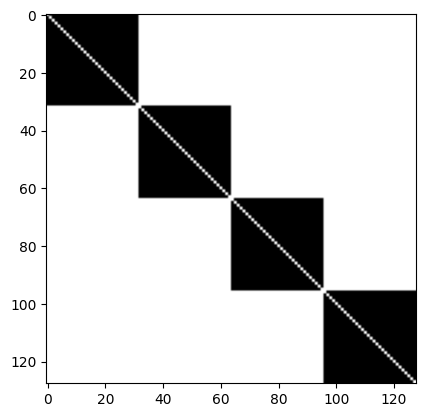

In [9]:
import bct
import matplotlib.pyplot as plt

# Create a graph with modules
n_nodes = 128
adj_mat_modular = bct.makeevenCIJ(n_nodes, 2000, 5)
adj_mat_modular = (adj_mat_modular + adj_mat_modular.T)/2  # make symmetric
plt.imshow(adj_mat_modular, cmap="binary");

In [10]:
model = Kuramoto(coupling=10, dt=0.01, T=150, n_nodes=n_nodes)                 
act_mat = model.run(adj_mat=adj_mat_modular)
print(act_mat.shape)

(128, 15000)


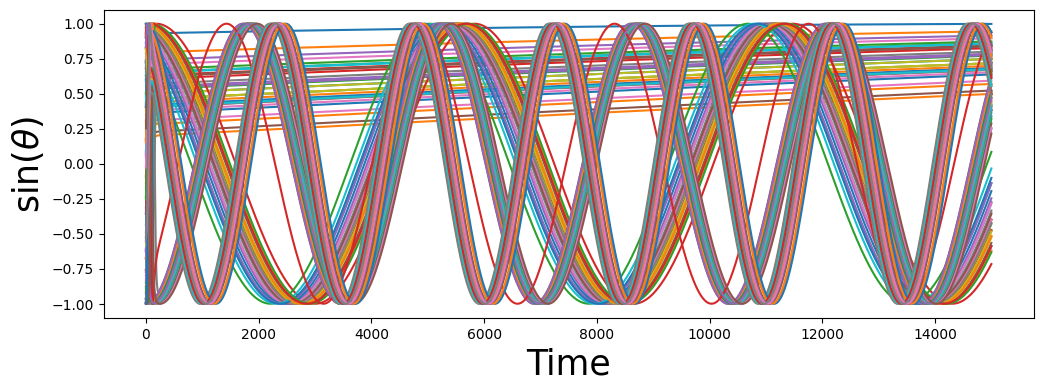

In [11]:
plot_activity(act_mat);

We see 4 bundles of time series, matching the number of modules, let's look at that in more detail

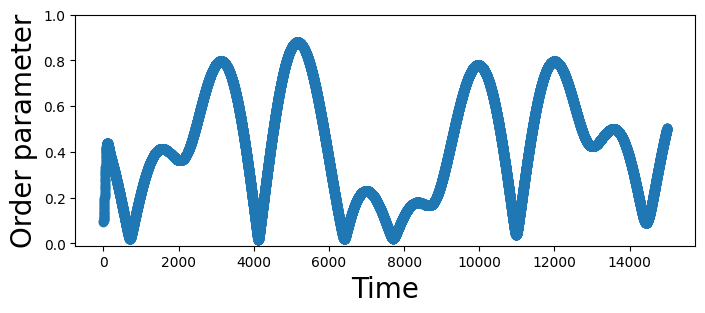

In [12]:
plot_phase_coherence(act_mat);

Plot snapshots of oscillators' positions, coloured by cluster

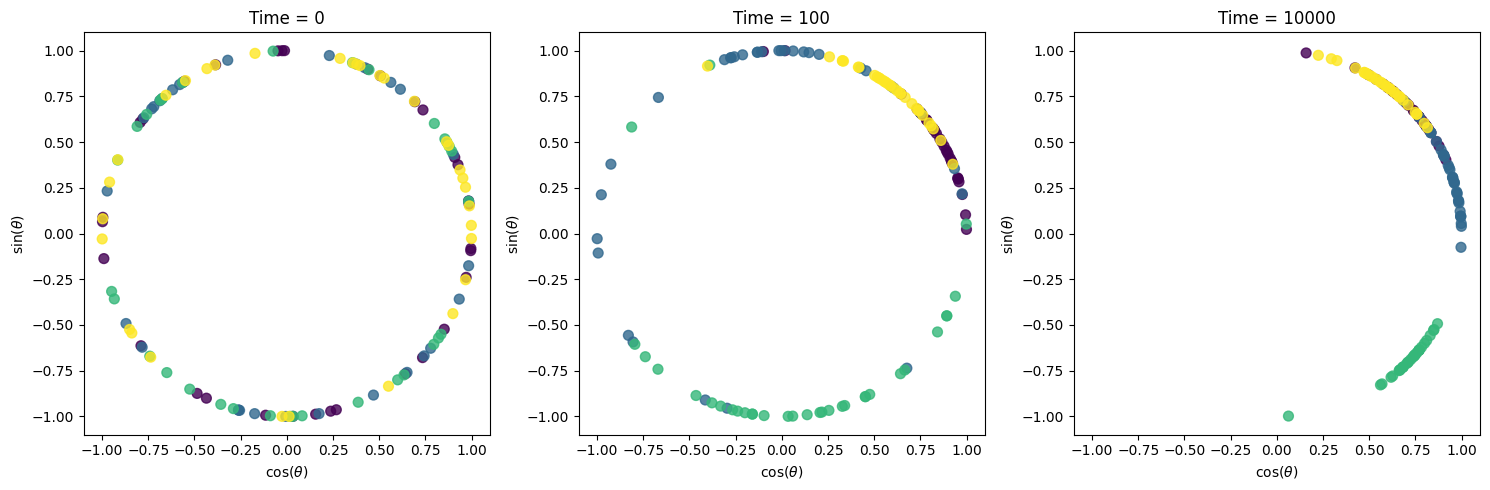

In [14]:
# Get cluster label for each node
aff_vec,_ = bct.modularity_louvain_und(adj_mat_modular)

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5),
                         subplot_kw={
                             "ylim": (-1.1, 1.1),
                             "xlim": (-1.1, 1.1),
                             "xlabel": r'$\cos(\theta)$',
                             "ylabel": r'$\sin(\theta)$',                             
                         })

times = [0, 100, 10000]
for ax, time in zip(axes, times):
    ax.scatter(
        np.cos(act_mat[:, time]), np.sin(act_mat[:, time]),  
        s=50, alpha=.8,
        c=aff_vec,  # color nodes by cluster
    )
    ax.set_title(f'Time = {time}')
    
plt.tight_layout();

The effect of the connectivity is pretty clear: Synchronization happens within but not across clusters of oscillators.